# Multiclass segmentation with the Lovász-Softmax

In [1]:
from __future__ import division, print_function

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn

In [5]:
import lovasz_losses as L

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
from utils import paletteVOC, pil_grid, dummy_triangles

In [7]:
from collections import OrderedDict as OD

In [8]:
def pil(array):
    im = Image.fromarray(array)
    im.putpalette(paletteVOC(PIL=True))
    return im

In [9]:
CUDA = True

In [10]:
def cuda(x):
    if CUDA:
        return x.cuda()
    else:
        return x

## Batch of 5 random images with classes [0, 1, 2] and void (255)

### Labels

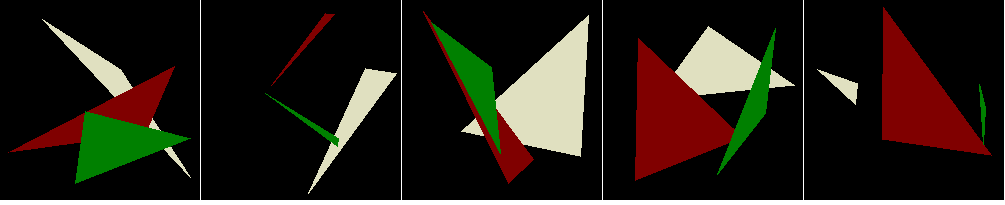

In [11]:
np.random.seed(18)
C = 3
B = 5
H = 200
labels_ = [dummy_triangles(H, [0, 255, 1, 2]) for b in range(B)]
labels = torch.stack(map(torch.from_numpy, map(np.array, labels_))).long()
pil_grid(labels_, 5, margin=1)

### Features

In [12]:
np.random.seed(57)
B, H, W = labels.size()
labels_ = labels.clone()
labels_[labels_ == 255] = labels_[labels_ == 255].random_(C) # random feats for void
labels_1hot = torch.zeros(B, C, H, W)
labels_1hot.scatter_(1, labels_.unsqueeze(1), 1);

In [36]:
feats = labels_1hot.clone().float()
feats += feats.new(feats.size()).normal_(0, 2) # additive gaussian noise

In [37]:
labels = cuda(labels)
feats = Variable(cuda(feats))

## Model

### definition

In [38]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, padding=1)
        
    def forward(self, x):
        return x + self.conv(x)

In [39]:
m = Model()
init_state_dict = OD([(n, p.clone()) for (n, p) in m.state_dict().items()])

In [40]:
m = cuda(m)

### Initial prediction

In [41]:
_, preds = m(feats).data.max(1)
print("Initial batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Initial mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Initial batch-IoUs: [ 42.8198754   12.04147301   8.22078907]
Initial mIoU: 21.0273791588


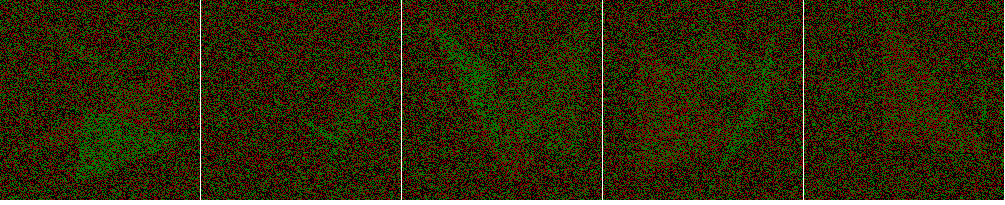

In [42]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Lovász-Softmax training

In [53]:
m.load_state_dict(init_state_dict)

optimizer = Adam(m.parameters(), lr=0.005)

loss_plot = []
iou_plot = []

for iter in tqdm(range(1000)):
    optimizer.zero_grad()
    out = m(feats)
    out = F.softmax(out)
    loss = L.lovasz_softmax(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    _, preds = out.data.max(1)
    loss_plot.append(loss.data[0])
    iou_plot.append(L.iou_binary(preds, labels, ignore=255, per_image=False))

Text(0.5,0,u'iteration')

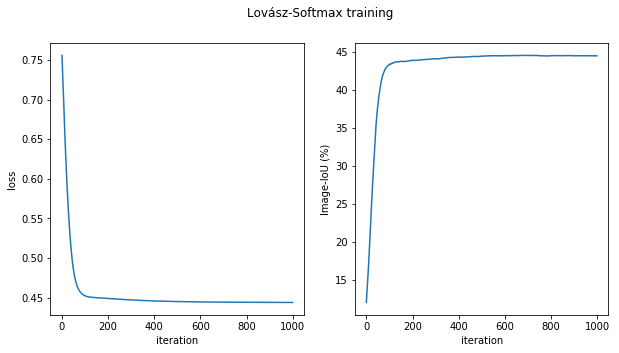

In [54]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Lovász-Softmax training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [55]:
_, preds = m(feats).data.max(1)
print("Final batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Final mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Final batch-IoUs: [ 87.6058982   44.50428308  33.12227074]
Final mIoU: 55.0774840093


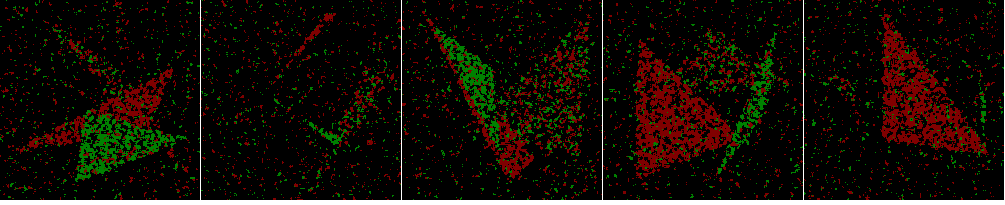

In [56]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Cross-entropy training

In [57]:
m.load_state_dict(init_state_dict)

optimizer = Adam(m.parameters(), lr=0.005)

loss_plot_x = []
iou_plot_x = []

for iter in tqdm(range(1000)):
    optimizer.zero_grad()
    out = m(feats)
    loss = L.xloss(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    _, preds = out.data.max(1)
    loss_plot_x.append(loss.data[0])
    iou_plot_x.append(L.iou_binary(preds, labels, ignore=255, per_image=False))

Text(0.5,0,u'iteration')

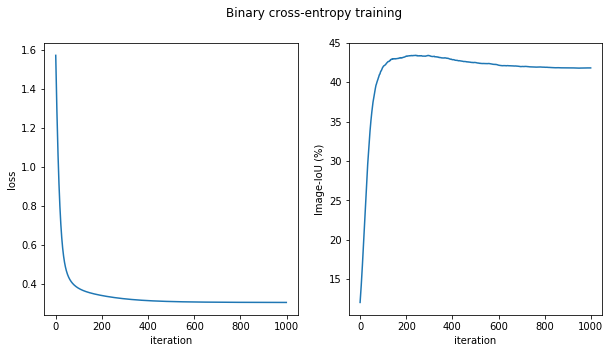

In [58]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Binary cross-entropy training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot_x)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot_x)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [59]:
_, preds = m(feats).data.max(1)
print("Final batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Final mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Final batch-IoUs: [ 88.65626032  41.81372549  29.0116998 ]
Final mIoU: 53.1605618714


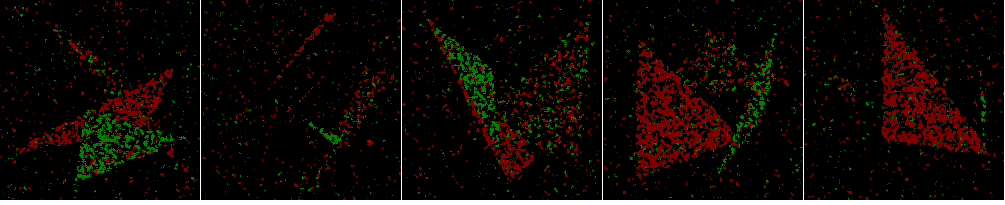

In [60]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)